In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import permutations
from pathlib import Path

# from dolfin import XDMFFile
# from dolfin import plot, lhs, rhs
# from dolfin import TestFunction, TrialFunctions
# from dolfin import RectangleMesh, Point, FiniteElement, MixedElement, FunctionSpace, Constant, Function, Measure
# from dolfin import TestFunctions, TrialFunctions, TrialFunction
# from dolfin import inner, grad, dx, ds, assemble
# from dolfin import solve
# from dolfin import FunctionSpace
# from dolfin import split
# from dolfin import Expression, Function, assign, project
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np


from pantarei.boundary import DirichletBoundary, process_dirichlet#, process_boundary_forms, process_dirichlet
from pantarei.domain import Domain
from pantarei.io import TimeSeriesStorage

from multirat.base.meshprocessing import Domain
from multirat.base.boundary import RobinBoundary, process_boundary_forms
from multirat.computers import BaseComputer
from multirat.parameters import get_base_parameters, compute_parameters, make_dimless, PARAMETER_UNITS, symmetric
from multirat.parameters import distribute_subset_parameters, print_quantities, to_constant, convert_to_units
from multirat.parameters import symmetrize

In [3]:
def multicompartment_parameters():
    base = get_base_parameters()
    distributed = distribute_subset_parameters(base)
    computed = compute_parameters(distributed)
    converted = convert_to_units(computed, PARAMETER_UNITS)
    params = make_dimless(converted)
    symmetrized = symmetrize(params, compartments, "convective_fluid_transfer",
           "convective_solute_transfer", "diffusive_solute_transfer")
    return symmetrized

In [4]:
compartments = ['ecs', 'pvs_arteries', 'pvs_capillaries', 'pvs_veins']
params = multicompartment_parameters()

In [5]:
# def create_mesh(n, x0=-1., y0=-1., z0=-1, x1=1., y1=1., z1=1.0):
#     return Domain(
#         mesh=BoxMesh(Point(x0, y0, z0), Point(x1, y1, z1), n, n, n),
#         subdomains=None,
#         boundaries=None,
#     )

def create_mesh(n, x0=-1., y0=-1., x1=1., y1=1.):
    return Domain(
        mesh=RectangleMesh(Point(x0, y0), Point(x1, y1), n, n),
        subdomains=None,
        boundaries=None,
    )


def solve_pressure(domain, V, compartments, boundaries, params):
    p = TrialFunctions(V)
    q = TestFunction(V)
    
    K, T = to_constant(params, "hydraulic_conductivity", "convective_fluid_transfer")
#     K = {key: Constant(val) for key, val in hydraulic_conductivity(params).items()}
#     T = get_interface_parameter(params["convective_fluid_transfer"], compartments, True)
#     T = {key: Constant(val) for key, val in T.items()}

    F = 0.0
    for idx_j, j in enumerate(compartments):
        F += (K[j] * inner(grad(p[idx_j]), grad(q[idx_j]))
            - sum([ T[(i, j)]*(p[idx_i] - p[idx_j])*q[idx_j] for idx_i, i in enumerate(compartments) if idx_i != idx_j])
        ) * dx
    bcs = []
    for idx_i, i in enumerate(compartments):
        bcs.extend(process_dirichlet(domain, V.sub(idx_i), boundaries[i]))
        F -= process_boundary_forms(p[idx_i], q[idx_i], domain, boundaries[i])
    A = assemble(lhs(F))
    b = assemble(rhs(F))

    P = Function(V, name="pressure")
    for bc in bcs:
        bc.apply(A, b)
        solve(A, P.vector(), b)
        
    return P

def pressure_functionspace(mesh, degree, compartments):    
    P1 = FiniteElement('CG', domain.mesh.ufl_cell(), degree)
    el = MixedElement([P1]* len(compartments))
    return FunctionSpace(mesh, el)
    
def store_pressure(filepath, p, compartments, store_xdmf=False):
    V = p.function_space()
    mesh = V.mesh()
    storage = TimeSeriesStorage("w", str(filepath), mesh=mesh, V=V)
    storage.write(p, 0.0)
    storage.close()
    if store_xdmf:
        visual = TimeSeriesStorage("r", storage.filepath)
        visual.to_xdmf(compartments)
        visual.close()
        
def print_progress(t, T):
    progress = int(20 * t / T)
    print(f"[{'=' * progress}{' ' * (20 - progress)}] {t / 60:>6.1f}min / {T / 60:<5.1f}min", end='\r')
    

def total_mass(c, phi, compartments):
    return sum([assemble(phi[i] * c[idx] * dx) for idx, i in enumerate(compartments)])


def solve_solute(c0, p, dt, T, domain, V, compartments, boundaries, params, results_path="../results/concentration/"):
    c = TrialFunctions(V)
    w = TestFunction(V)
    
    # TODO: Move to single function.
#     phi = {key: Constant(val) for key, val in params["porosity"].items()}
#     D = {key: Constant(val) for key, val in params[f"effective_diffusion"].items()}
#     K = {key: Constant(val) for key, val in params[f"hydraulic_conductivity"].items()}
#     G = get_interface_parameter(params["convective_solute_transfer"], compartments, True)
#     G = {key: Constant(val) for key, val in G.items()}
#     L = get_interface_parameter(params["diffusive_solute_transfer"], compartments, True)
#     L = {key: Constant(val) for key, val in L.items()}
    phi, D, K, G, L = to_constant(params, "porosity", "effective_diffusion", "hydraulic_conductivity",
                     "convective_solute_transfer", "diffusive_solute_transfer")
    
    # Index map, name to number index of subspace.
    # TODO: Exchange index map by enumerate everywhere.
    F = 0.0
    C0 = project(c0, V)
    for idx_j, j in enumerate(compartments):
        F += (c[idx_j] - C0[idx_j]) * w[idx_j] * dx
        F += dt * (inner(D[j] * grad(c[idx_j]) + K[j]/phi[j] * c[idx_j] * grad(p[idx_j]), grad(w[idx_j]))) * dx
        sj = 0.0
        for idx_i, i in enumerate(compartments):
            if idx_i == idx_j:
                continue
            sj += (L[(i, j)] * (c[idx_i] - c[idx_j])
                   + G[(i, j)] * (p[idx_i] - p[idx_j]) * (0.5 * (c[idx_i] + c[idx_j]))
                ) / phi[j]
        F -= dt * sj * w[idx_j] * dx
        
    bcs = []
    for idx_i, i in enumerate(compartments):
        bcs.extend(process_dirichlet(domain, V.sub(idx_i), boundaries[i]))
        F -= dt * process_boundary_forms(c[idx_i], w[idx_i], domain, boundaries[i])
    a = lhs(F)
    l = rhs(F)
    A = assemble(a)
    
    storage = TimeSeriesStorage("w", results_path, mesh=domain.mesh, V=V)
    t = Constant(0.0)
    storage.write(C0, t)
    mass = np.nan * np.zeros(int(T / dt) + 1)
    idx = 0
    mass[idx] = total_mass(C0, phi, compartments)
    C = Function(V, name="concentration")
    while float(t) < T:
        print_progress(float(t), T)
        A = assemble(a)
        b = assemble(l)
        for bc in bcs:
            bc.apply(A, b)
            solve(A, C.vector(), b)
        C0.assign(C)
        t.assign(t + dt)
        storage.write(C, t)
        
        idx += 1
        mass[idx] = total_mass(C0, phi, compartments)
    storage.close()
    
    visual = TimeSeriesStorage("r", storage.filepath)
    visual.to_xdmf(compartments)
    visual.close()
    
    np.savetxt("../results/concentration/mass.txt", mass)
    return C, mass

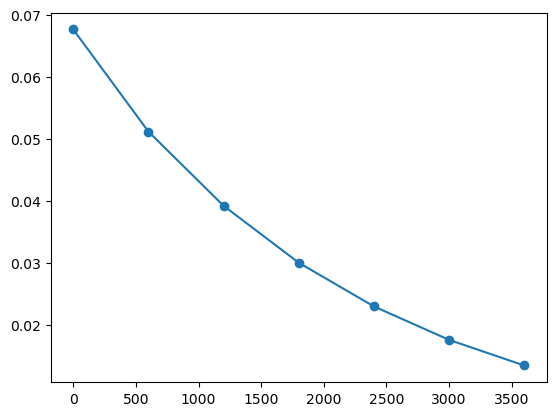

In [6]:
domain = create_mesh(40)
V = pressure_functionspace(domain.mesh, degree=1, compartments=compartments)

# Boundary conditions
L_bdry = params["hydraulic_conductivity_bdry"]
p_bdry = params["pressure_boundaries"]
boundaries = {
    "ecs": [RobinBoundary(L_bdry["ecs"], p_bdry["ecs"], "everywhere")],
    "pvs_arteries": [RobinBoundary(L_bdry["pvs_arteries"], p_bdry["pvs_arteries"], "everywhere")],
    "pvs_capillaries": [],
    "pvs_veins": [DirichletBoundary(p_bdry["pvs_veins"], "everywhere")],
}

results_path = Path("../results/pressure").resolve()
p = solve_pressure(domain, V, compartments, boundaries, params)
store_pressure(results_path, p, compartments, store_xdmf=True)


solute_bcs = {
    "ecs": [DirichletBoundary(Constant(0.0), "everywhere")],
    "pvs_arteries": [DirichletBoundary(Constant(0.0), "everywhere")],
    "pvs_capillaries": [DirichletBoundary(Constant(0.0), "everywhere")],
    "pvs_veins": [DirichletBoundary(Constant(0.0), "everywhere")],
}

dt  = 600  # 10min timestep.
T = 1 * 3600 # 4h
N = int(T / dt) + 1

c_init = Expression("exp(-(pow(x[0] - c[0], 2) + pow(x[1]-c[1], 2)) / (length * length))",
                    length=Constant(0.4), c=Constant((0.5, 0.0)), degree=2)

c0 = Function(V)
assign(c0.sub(0), project(c_init, V.sub(0).collapse()))


times = np.array([dt * i for i in range(N)])
C, mass = solve_solute(c0, p, dt, T, domain, V, compartments, solute_bcs, params)

plt.figure()
plt.plot(times, mass, "o-")
plt.show()